In [29]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score, mutual_info_score, adjusted_mutual_info_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from kneed import KneeLocator
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
import warnings
warnings.filterwarnings("ignore")

In [2]:
f = open(r"deezer_ego_nets/deezer_edges.json")
graphs = json.load(f)
f.close()

In [3]:
labels = pd.read_csv(r"deezer_ego_nets/deezer_target.csv")

In [4]:
graph_list = [nx.Graph(graphs[str(x)]) for x in range(len(graphs.keys()))]
adjacency_matrices = [nx.adjacency_matrix(graph) for graph in graph_list]
flattened_matrices = [np.matrix.flatten(mat.todense()) for mat in adjacency_matrices]

to_remove_indices = [x[0] for x in enumerate(flattened_matrices) if len(x[1]) > 1000]
flattened_matrices = [x for x in flattened_matrices if len(x) < 1000]

print(len(to_remove_indices))

1622


In [5]:
labels.drop(to_remove_indices, inplace=True)

In [6]:
max_size = 0

for arr in flattened_matrices:
    max_size = max(max_size, len(arr))

for i, arr in enumerate(flattened_matrices):
    flattened_matrices[i] = np.concatenate([arr, np.zeros(max_size - len(arr))])

In [7]:
data_df = pd.DataFrame(np.stack(flattened_matrices, axis=0))
normalized_features_df = (data_df-data_df.mean())/data_df.std()
normalized_features_df.dropna(axis = 1, how = 'all', inplace = True)

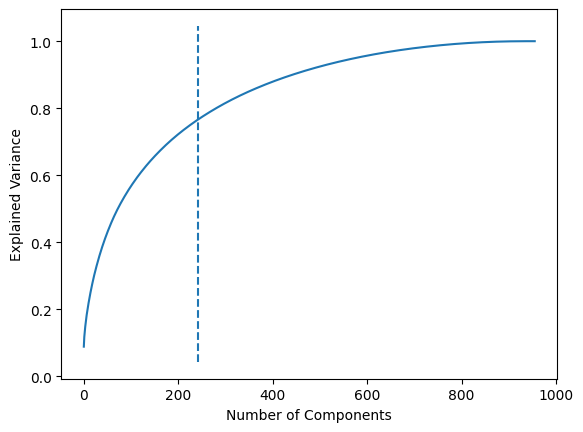

Optimal number of components - 242


In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from kneed import KneeLocator

pca = PCA().fit(normalized_features_df)
ex_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(ex_var_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

kn = KneeLocator(range(1, len(ex_var_ratio) + 1),
                 ex_var_ratio,
                 direction='increasing')

plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

plt.show()

print("Optimal number of components - %s" % kn.knee)

In [11]:
df_pca = PCA(n_components=kn.knee).fit_transform(normalized_features_df)
df_pca = pd.DataFrame(df_pca)

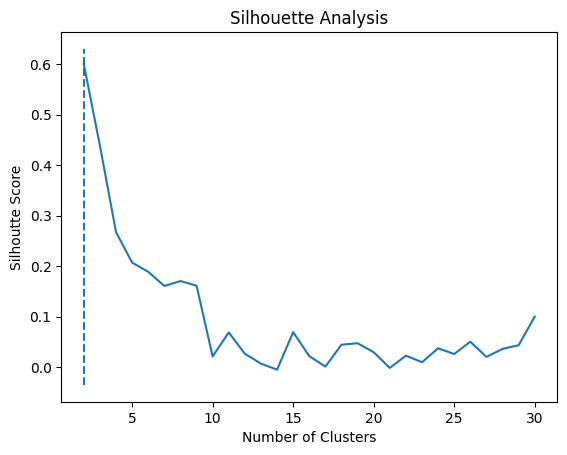

In [13]:
# silhouette analysis
s_scores = []
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_pca)
    s_scores.append(silhouette_score(df_pca, kmeans.labels_))

plt.plot(range(2, 31), s_scores)

kn = KneeLocator(range(1, len(s_scores) + 1),
                 s_scores,
                 direction='increasing')

plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    
plt.xlabel("Number of Clusters")
plt.ylabel("Silhoutte Score")
plt.title('Silhouette Analysis')
plt.show()

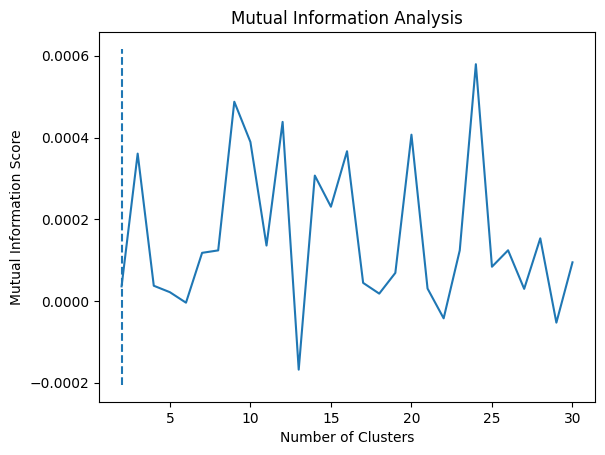

In [14]:
# mutual information analysis
s_scores = []
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_pca)
    s_scores.append(adjusted_mutual_info_score(labels["target"], kmeans.labels_))

plt.plot(range(2, 31), s_scores)

kn = KneeLocator(range(1, len(s_scores) + 1),
                 s_scores,
                 direction='increasing')

plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    
plt.xlabel("Number of Clusters")
plt.ylabel("Mutual Information Score")
plt.title('Mutual Information Analysis')
plt.show()

**We chose 2 clusters**

In [17]:
kmeans = KMeans(n_clusters=2).fit(df_pca)
dbscan = DBSCAN().fit(df_pca)
gmm = GMM(n_components=2).fit(df_pca)
models = [kmeans, dbscan, gmm]
model_labels = [kmeans.labels_, dbscan.labels_, gmm.predict(df_pca)]

In [19]:
mi_genre_kmeans = mutual_info_score(labels["target"], model_labels[0])
mi_genre_dbscan = mutual_info_score(labels["target"], model_labels[1])
mi_genre_gmm = mutual_info_score(labels["target"], model_labels[2])

sil_genre_kmeans = silhouette_score(df_pca, model_labels[0])
sil_genre_dbscan = silhouette_score(df_pca, model_labels[1])
sil_genre_gmm = silhouette_score(df_pca, model_labels[2])

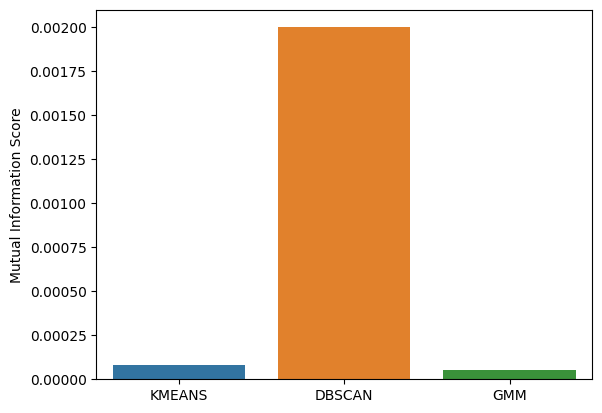

In [21]:
sns.barplot(x=["KMEANS", "DBSCAN", "GMM"], y=[mi_genre_kmeans, mi_genre_dbscan, mi_genre_gmm])
plt.ylabel("Mutual Information Score")
plt.show()

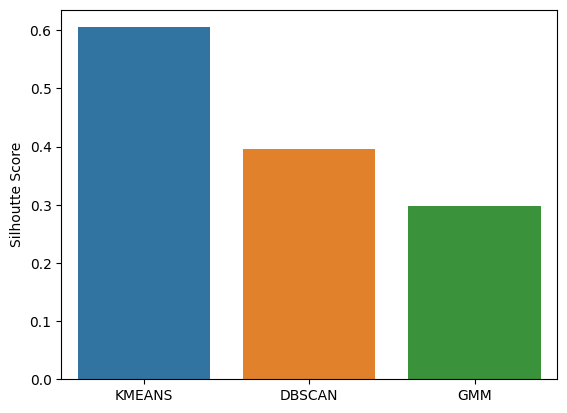

In [20]:
sns.barplot(x=["KMEANS", "DBSCAN", "GMM"], y=[abs(sil_genre_kmeans), abs(sil_genre_dbscan), abs(sil_genre_gmm)])
plt.ylabel("Silhoutte Score")
plt.show()

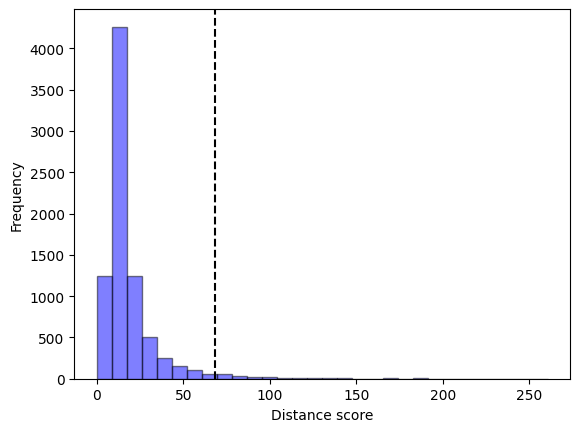

Threshold: 68.20261354545508
The anomalies percent for K-means is 2.273011115274135%


In [24]:
km = KMeans()
km.fit(df_pca)
scores = km.transform(df_pca).min(axis=1)

plt.hist(scores, bins=30, color='b', alpha=0.5, edgecolor='black')

thresh = np.mean(scores) + 3 * np.std(scores)
plt.axvline(x=thresh, color='black', linestyle='--', linewidth=1.5)

plt.xlabel('Distance score')
plt.ylabel('Frequency')

plt.show()

print(f'Threshold: {thresh}')
print(f'The anomalies percent for K-means is {100 * len([i for i in scores if i > thresh]) / len(scores)}%')

Threshold: 527.9325378191771
The anomalies percent for one class SVM is 5.257899338079181%


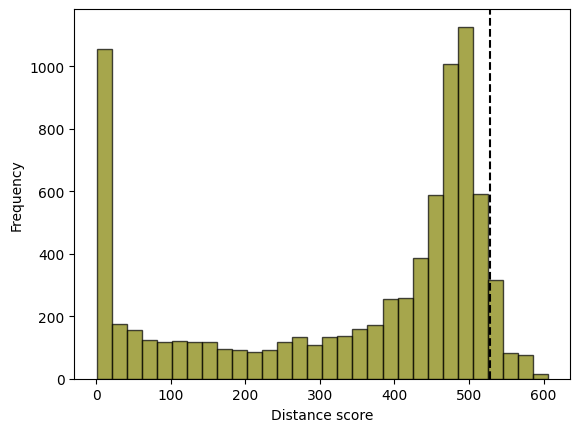

In [28]:
clf = OneClassSVM(gamma='auto')
clf.fit(df_pca)
scores = clf.score_samples(df_pca)

plt.hist(scores, bins=30, color='olive', alpha=0.7, edgecolor='black')

thresh = np.mean(scores) + 1 * np.std(scores)
plt.axvline(x=thresh, color='black', linestyle='--', linewidth=1.5)

print(f'Threshold: {thresh}')
print(f'The anomalies percent for one class SVM is {100 * len([i for i in scores if i > thresh]) / len(scores)}%')

plt.xlabel('Distance score')
plt.ylabel('Frequency')
plt.show()

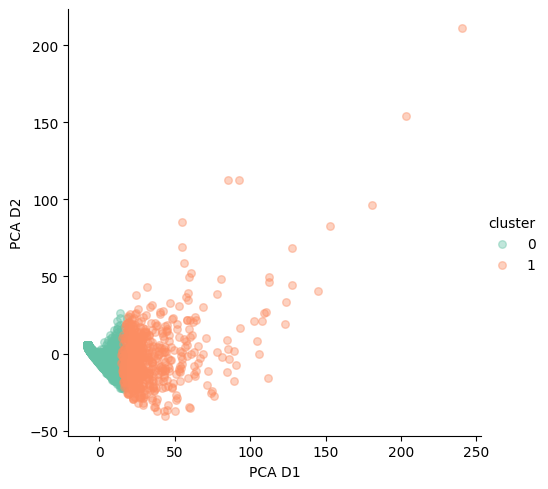

In [31]:
pca = PCA(n_components=2)           
reduced_features_df = pca.fit_transform(df_pca)
comp_x, comp_y = zip(*reduced_features_df)
df_pca['x'] = comp_x
df_pca['y'] = comp_y
df_pca['cluster'] = kmeans.labels_
sns.lmplot(data=df_pca, x='x', y='y', hue='cluster', fit_reg=False, height=5, palette='Set2', scatter_kws={'alpha':0.4, 's':30})
plt.xlabel("PCA D1")
plt.ylabel("PCA D2")
plt.show()